In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
import pandas as pd
from scipy import stats
from scipy.signal import find_peaks
import datetime
from scipy.stats import fit
from scipy.stats import genextreme
from scipy.stats import genpareto

## Sand - Production

In [22]:
load_time = 90*60 #s
rho_s = 2000 #kg/m3 soil density in-situ
rho_m = 1500 #kg/m3 
rho_w = 1025 #kg/m3
w = 220 #m
l = 1000 #m
delta_d = 4 #m (max allowed dredging - current depth)
d = 12 #m (Channel depth for sediment inflow)
mass_sand = rho_s * w * l * delta_d #kg
vol_sand = mass_sand / rho_s #m3
avg_load_rate = vol_sand / load_time #m3/s
S = 250 + 260 * d**1.4

print('Sediment Inflow Rate:', round(S,3), 'kg/week/m')
print('Total material dredged :', round(mass_sand/1000,1) , 'ton')
print('Volume of Sand:', round(vol_sand,5) , 'm3')
print('Average load rate:', round(avg_load_rate,3), 'm3/s')

Sediment Inflow Rate: 8679.991 kg/week/m
Total material dredged : 1760000.0 ton
Volume of Sand: 880000.0 m3
Average load rate: 162.963 m3/s


In [23]:
phi = 15
k_i = 0.000000001 #m/s
k_o = 0.000001 #m/s 

#Cross sectional area trench 
def A_trench(B, H, phi):
    phi_rad = phi*np.pi/180
    A = H*(B+H/np.tan(phi_rad))
    
    return A

In [24]:
#Mixture Density
rho_m = 1500 #kg/m3, density of the soil in situ 

#Dilatancy
n1 = 0.35 #porosity loose 
def calc_dn(n0,n1):
    return(n1-n0)/(1-n1)

print('Delta n:', calc_dn(0.35,0.45))

Delta n: 0.18181818181818185


In [25]:
#Breaching Velocity
def cot(x):# x in degrees
    rad = x*np.pi/180
    return np.cos(rad)/np.sin(rad)

def calc_vz(k,dn,phi,beta,rho_m,rho_w):
    return k/dn *( cot(phi) - cot(beta)) * ((rho_m-rho_w)/rho_w)

vz = calc_vz(k = 2.5e-5, dn = calc_dn(0.35,0.45), phi = 30, beta = 90, rho_m = rho_m, rho_w = 1025)
print('The horizontal velocity (vz):', vz, 'm/s')

The horizontal velocity (vz): 0.00011036543255545591 m/s


In [26]:
#Production
A = A_trench(B = 220, H = 10, phi = 30)
vz = vz
P = vz * A
p_hourly = P * 3600

print('The cross sectional area (A):', round(A,1) , 'm2')
print('The wall velocity (vz):', round(vz,5) , 'm/s')
print('production (P):', round(P,3), 'm3/s =', round(p_hourly,2), 'm3/h')   

The cross sectional area (A): 2373.2 m2
The wall velocity (vz): 0.00011 m/s
production (P): 0.262 m3/s = 942.91 m3/h


Hydraulic Transport Calculation

In [27]:
#Mixture Velocity
D = 0.8 #m, suction tube diameter  
def calc_vm(Qg,rho_s, rho_w, rho_m, n0, D, ft = 1):
    return Qg*(rho_s-rho_w)*(1-n0) / ((rho_m-rho_w)*np.pi/4*D**2) /ft

# Qg = 3600 m3/h = 1 m3/s average total soil discharge 
calc_vm(Qg = 1,rho_s = 2000, rho_w = 1025, rho_m = 1500, n0 = 0.45, D=0.8)

2.24596942718497

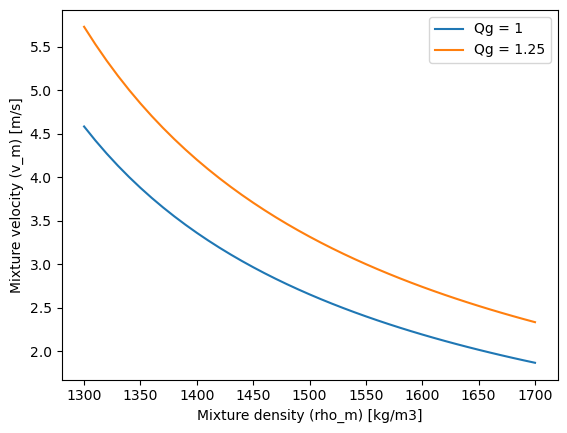

In [28]:
# Q peak = Q avg/ eta = 1/0.8 = 1.25 m3/s

rho_serie = np.arange(1300,1700+10,10) #because the average rho_m is 1500 as per assignment details 
vm_avg = []
vm_peak = []

vm_serie = np.arange(2.5,7,0.1)

for rho_m in rho_serie:
    vm_avg.append(calc_vm(Qg = 1,rho_s = 2000, rho_w = 1025, rho_m = rho_m, n0 = 0.35, D=0.8))
    vm_peak.append(calc_vm(Qg = 1.25,rho_s = 2000, rho_w = 1025, rho_m = rho_m, n0 = 0.35, D=0.8))

plt.plot(rho_serie, vm_avg, label = 'Qg = 1');
plt.plot(rho_serie, vm_peak, label = 'Qg = 1.25');
plt.xlabel('Mixture density (rho_m) [kg/m3]')
plt.ylabel('Mixture velocity (v_m) [m/s]');
plt.legend();

In [29]:
#Pressure Loss

def calc_Delta_P(lambda_, rho_m,rho_w,L,D,v):
    g=9.81
    return 1/2*lambda_ * rho_m /rho_w *L/D*(v**2)/g*rho_m*g

v = 1/(0.25*np.pi*D**2) # Q (1 m3/s) / A [m2] 

DeltaP1 = calc_Delta_P(lambda_ = 0.012, rho_m = rho_m, rho_w=1025, L = 3000, D = 0.8, v = v) #L and lambda_ parameters are still vague

def calc_Delta_P2(rho_m,He):
    return rho_m*9.81*He

DeltaP2 = calc_Delta_P2(1400,5)

Delta_P = DeltaP1 + DeltaP2
print('The total pressure loss is: ', round(Delta_P/1000,1), 'kN/m2')

The total pressure loss is:  319.8 kN/m2


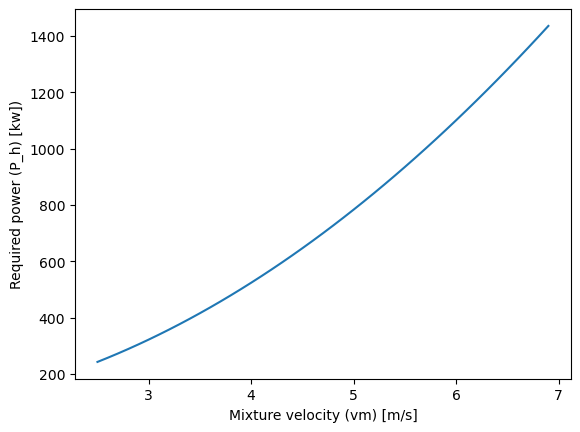

In [30]:
#Power for Hydraulic Transport 
Ph_serie = []
power = [] #or directly: power = delta_p * Q / efficiency, so the density is actually irrelevant

def calc_rho_m(Q,A,n,ft,rho_s,rho_w,vm):
    C1 = Q/A * (1-n) / ft
    return (C1*rho_s - C1*rho_w + rho_w*vm)/vm

for vm in vm_serie:
    rho_m = calc_rho_m(Q=1,A=A,n=0.35,ft=1,rho_s = 2000,rho_w = 1025,vm = vm)# function is correct
    P1 = calc_Delta_P(lambda_ = 0.012, rho_m = rho_m, rho_w=1025, L = 3000,D = D,v = vm)# function is correct
    P2 = calc_Delta_P2(rho_m,5)
    Delta_P = P1 + P2 # correct
    Ph_serie.append(1*Delta_P/1000/0.8)#to kw
    power.append(Delta_P/1000/0.8)

plt.plot(vm_serie, Ph_serie);
plt.xlabel('Mixture velocity (vm) [m/s]')
plt.ylabel('Required power (P_h) [kw])');

In [31]:
for vm in vm_serie:
    rho_m = calc_rho_m(Q=1,A=A,n=0.35,ft=1,rho_s = 2000,rho_w = 1025,vm = vm)# function is correct
    P1 = calc_Delta_P(lambda_ = 0.012, rho_m = rho_m, rho_w=1025,L = 3000,D = D,v = vm)# function is correct
    P2 = calc_Delta_P2(rho_m,5)
    Delta_P = P1 + P2 # correct
    Ph = 1*Delta_P/1000/0.8
    
    #print(round(rho_m,0), 'kg/m3 when', round(Ph,0), 'kW')
    if rho_m<=1500:
        print('The lowest power to prevent clogging is', round(Ph,2) , 'kW')
        break

The lowest power to prevent clogging is 243.07 kW


## Energy Consumption and Emissions

In [32]:
#Hydraulic Power for Dredging
def calc_P(Q,H,rho_m,eta):
    return Q*H*rho_m*9.81/eta

P_dredge = calc_P(Q = 1,H = 10, rho_m = rho_m,eta = 0.8) #Hydraulic Head Parameter is still Vague
print('The required hydraulic power for dredging', round(P_dredge,0), 'W')

The required hydraulic power for dredging 125704.0 W


In [33]:
t_dredge = 30*60#seconds
E_dredge = t_dredge * P_dredge
E_dredge_propulsion = 200000*30*60 #How much is the energy required to keep vessel in place? 
print('The thruster require:', E_dredge_propulsion, 'J')
print('The required energy for dredging is', round(E_dredge,0),'J')

The thruster require: 360000000 J
The required energy for dredging is 226266702.0 J


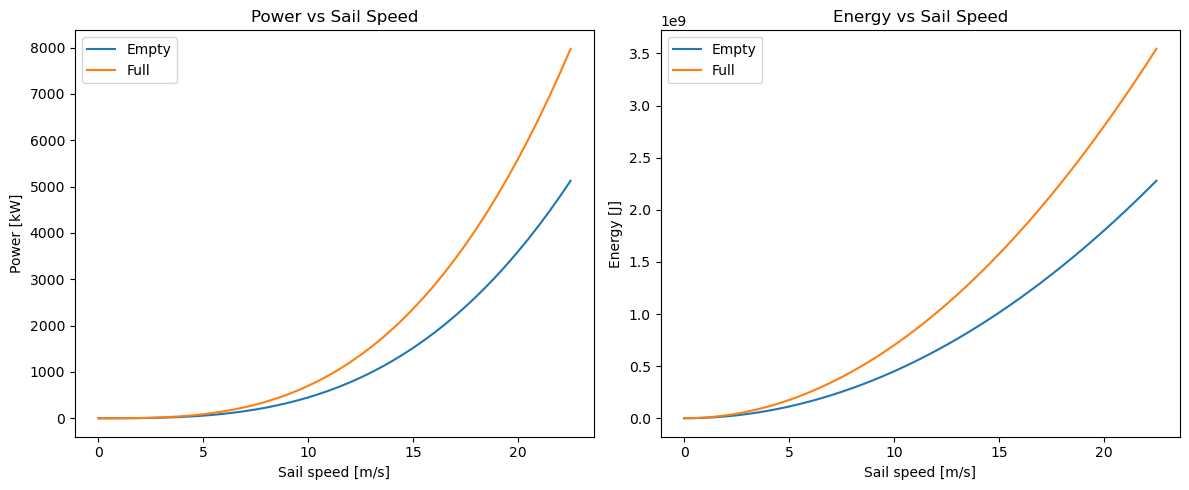

In [34]:
## Sailing

def calc_P_sail(v,c):
    return c * v**3

v_serie = np.arange(0,12*1.852+0.5,0.5) #1knot = 1.852km/h

P_empty =[]
P_full = []
for v in v_serie:
    P_empty.append(calc_P_sail(v,450)/1000)
    P_full.append(calc_P_sail(v,700)/1000)

def calc_E_sail(s, v, c_sail):
    P_sail = c_sail*v**3
    t = s/v
    return P_sail * t

v_serie = np.arange(0.001,12*1.852+0.5,0.5)

#Total Energy for Loading and Unloading (10 km from disposal area)
E_empty =[]
E_full = []
for v in v_serie:
    E_empty.append(calc_E_sail(s=10000, v=v, c_sail=450))
    E_full.append( calc_E_sail(s=10000, v=v, c_sail=700))

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(v_serie, P_empty, label='Empty')
axs[0].plot(v_serie, P_full, label='Full')
axs[0].legend()
axs[0].set_xlabel('Sail speed [m/s]')
axs[0].set_ylabel('Power [kW]')
axs[0].set_title('Power vs Sail Speed')

# Second plot: Energy vs Sail speed
axs[1].plot(v_serie, E_empty, label='Empty')
axs[1].plot(v_serie, E_full, label='Full')
axs[1].legend()
axs[1].set_xlabel('Sail speed [m/s]')
axs[1].set_ylabel('Energy [J]')
axs[1].set_title('Energy vs Sail Speed')

# Show the plots side by side
plt.tight_layout()
plt.show()
    

In [35]:
## Manuevers (Parameters used still based on TS2)
E_maneuvre_empty = calc_P_sail(v=8*1.852,c=450) * (5*60) # P_sail(8 knots) * t
E_maneuvre_full = calc_P_sail(v=4*1.852,c=700) * (10*60)
print('Energy use while Empty:', round( E_maneuvre_empty/1000,0) , 'kW')
print('Energy use while Full:',  round( E_maneuvre_full/1000, 0) , 'kW')

Energy use while Empty: 439063.0 kW
Energy use while Full: 170747.0 kW
